In [1]:
import xarray as xr
import cftime
import pandas as pd
import numpy as np
import netCDF4
import os
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


# Rain and Wind Onset

This script calculates the first date each grid cell receives 12mm of rainfall over 2 weeks, not followed by a similar dry spell, as well as the first date each grid cell has a 95th percentile daily mean wind speed in reanalysis data.
Data is limited to August through November. 
Because it is using high resolution data, this was run on a server. It can be run on a local machine, but will be very slow, and take up a lot of memory.

Load variables

In [2]:
model_directory = '/ERA5/'

directory = model_directory+'/pr/'
pr_dir = directory+'/'+'era5_pr_1981_2010.nc'
directory = model_directory+'/'+'/sfcWind/'
sfcWind_dir = directory+'/'+'era5_sfcWind_1981_2010.nc'
pr = xr.open_dataset(pr_dir)
sfcWind = xr.open_dataset(sfcWind_dir)
sfcWind_vals = sfcWind.wspd10mean
pr_vals = pr.prec

Define the threshold that strong wind is defined at
and limit data to time period of interest

In [ ]:
testing_percentile = .95

months = [7,8,9,10,11,12]
time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
pr_vals = pr_vals.isel(day = time_index)
pr_vals = pr_vals.rename({'day':'time'})


UV = sfcWind_vals
wind_prctiles = UV.quantile(testing_percentile,dim="day")
months = [8,9,10,11,12]
time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
UV = UV.isel(day = time_index)

# find where wind exceeds the percentile
wd = xr.where(UV > wind_prctiles,1,0)
wd = wd.rename({'day':'time'})

Calculate the first rain and wind each not, where rain is not followed by a similar dry spell

In [ ]:
# empty variables to add data to
fire_weather = []
all_first_wd= []
all_first_wet = []
for i in range(len(pr_vals.groupby('time.year'))):
    # calculate 1 year at a time
    testyear = 1981+i
    # select wind exceedance binary for that year
    wd_testing_year = wd.sel(time=wd.time.dt.year.isin([testyear]))
    # first wind date
    first_wd = wd_testing_year.argmax('time')
    # find grid cells where there is never wind
    all_zeroes = (wd_testing_year==0).all(dim='time')
    # turn those grid cells into nan (if they are 0 it will show as an early wind)
    # you could change it to a max value, like 121 or something, under the assumption that if wind doesn't happen 
    # aug-dec, it happens "late", but this would be creating data. Turning it into nans just ignores those dates
    new_first_wd = xr.where(all_zeroes,np.nan,first_wd)
    # add first wind dates to the array
    all_first_wd.append(new_first_wd)   
    
    
    # rain
    # Select the precipitation data for the testing year
    prcp_year = pr_vals.sel(time=pr_vals.time.dt.year.isin([testyear]))
    # gotta include july, then cut it out
    fall_prcp = prcp_year.sel(time=prcp_year['time.month'] >= 7)
    fall_prcp = fall_prcp.sel(time=fall_prcp['time.month'] < 12)
    # Select the 2-week periods
    fall_prcp_rolling_back = fall_prcp.rolling(time=14).sum(dim='time').fillna(0)
    # limit to august forward
    months = [8,9,10,11,12]
    time_index = [i for i, month in enumerate(fall_prcp_rolling_back.time.dt.month) if month in months]
    fall_prcp_rolling_back = fall_prcp_rolling_back.isel(time = time_index)
    
    fall_prcp_rolling_forward = fall_prcp.rolling(time=14,min_periods=1).sum(dim='time').fillna(0)
    time_index = [i for i, month in enumerate(fall_prcp_rolling_forward.time.dt.month) if month in months]
    fall_prcp_rolling_forward = fall_prcp_rolling_forward.isel(time = time_index)
    # back rolling above 12mm
    new_wet_cond = fall_prcp_rolling_back > 12
 
    # forward rolling under 12
    dry_spell = fall_prcp_rolling_forward < 12
 
    wet_cond_without_dry = new_wet_cond.where(~dry_spell).fillna(0)
 
    first_wet_week = wet_cond_without_dry.argmax('time')
    all_zeroes = (wet_cond_without_dry==0).all(dim='time')
    first_wet_week = xr.where(all_zeroes,np.nan,first_wet_week)
    all_first_wet.append(first_wet_week)

In [30]:
first_wet_hist = xr.concat(all_first_wet,dim='newyear')
first_wind_hist = xr.concat(all_first_wd,dim='newyear')

In [ ]:
# Save the files
wet_file = '/era5_1981_2010_first_wet_nans_dry_spell.nc'
first_wet_hist.to_netcdf(wet_file)
wind_file= '//era5_1981_2010_first_wind_nans.nc'
first_wind_hist.to_netcdf(wind_file)

# Plotting

In [2]:
coords = xr.open_dataset('/Users/gt7/Desktop/Research/downscaled_data/coords/wrfinput_d02_coord.nc')
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
# Custom colormap for rain onset
import matplotlib.colors
twelve_color_cmap3 = matplotlib.colors.ListedColormap(["snow","lemonchiffon","lightcoral","lightsalmon","gold",
                                                                   "palegreen","mediumseagreen","seagreen",
                                                                   "cornflowerblue","royalblue","slateblue"])

# ERA5 Rain Onset

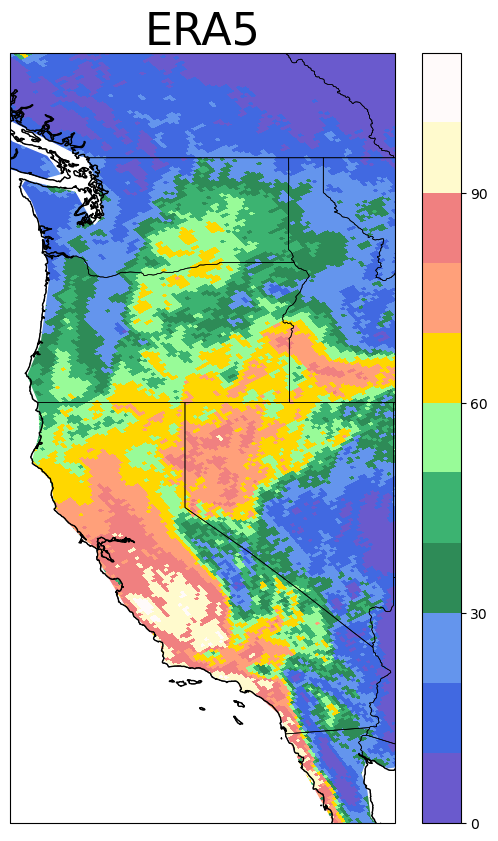

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

first_wet_era5 = xr.open_dataset('/era5/era5_1981_2010_first_wet_nans.nc')
first_wet_era5 = first_wet_era5.__xarray_dataarray_variable__
era5_wet_mean = first_wet_era5.mean(dim='newyear')

fig = plt.figure(1, figsize=[7, 10])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
im = plt.pcolormesh(coords['lon2d'], coords['lat2d'], era5_wet_mean.values,cmap=twelve_color_cmap3.reversed(),vmin=0, vmax=110)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
ax.add_feature(ocean)
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.set_ylim(30, 52)
ax.set_xlim(-125, -114)
cbar = plt.colorbar(im)
tick_spacing = 30
cbar.locator = MultipleLocator(base=tick_spacing)
cbar.update_ticks()
plt.title('ERA5',fontsize=32)
plt.show()

# ERA5 Wind Onset

In [8]:
# new colormap - maybe 1 color for each month?

five_color_cmap = matplotlib.colors.ListedColormap(["lightcoral","gold","mediumseagreen","royalblue"])



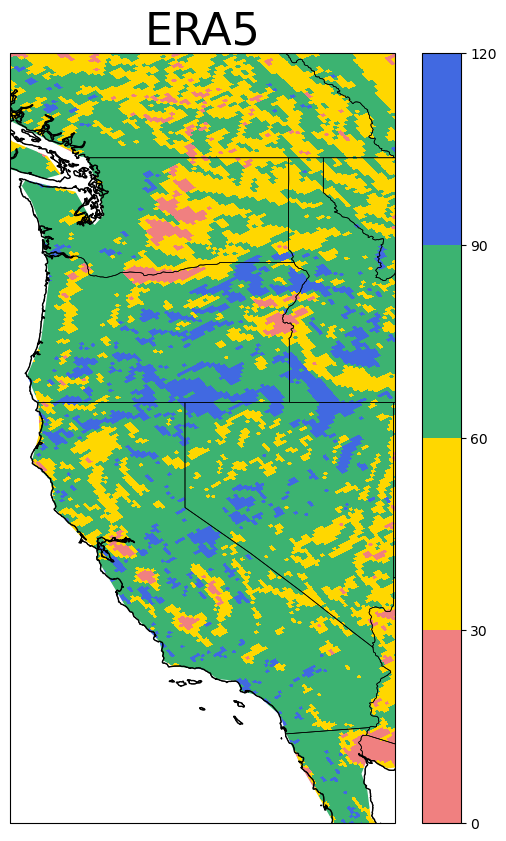

In [9]:
first_wind_era5 = xr.open_dataset('//era5_1981_2010_first_wind_nans.nc')
era5_wind_mean = first_wind_era5.mean(dim='newyear')


fig = plt.figure(1, figsize=[7, 10])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
im = plt.pcolormesh(coords['lon2d'], coords['lat2d'], era5_wind_mean.wspd10mean,vmin=0,vmax=120,cmap=five_color_cmap)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
ax.add_feature(ocean)
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.set_ylim(30, 52)
ax.set_xlim(-125, -114)
cbar = plt.colorbar(im)
tick_spacing = 30
cbar.locator = MultipleLocator(base=tick_spacing)
cbar.update_ticks()
plt.title('ERA5',fontsize=32)
plt.show()